In [1]:

import sys
import os
import pandas as pd
# Add the path to the script if it's not in the same directory
sys.path.append("../scripts")  # Adjust this path

from ab_testing import perform_anova_test, perform_anova_test_regularized, perform_kruskal_wallis, test_hypothesis, ab_test
from utils import count_group_contribution, create_bar_chart, create_grouped_bar_chart, create_boxplot
from data_prep import load_data, calculate_profit, group_zip_codes

### Load the data

In [2]:
file_path = "../data/MachineLearningRating_v3.txt"

data = load_data(file_path)

### Test 1: Risk Differences Across Provinces

*   **Null Hypothesis (H₀):** There is no significant difference in risk levels between provinces.
*   **Alternative Hypothesis (H₁):** There are significant differences in risk levels between provinces.

**1. Defining Key Performance Indicators (KPIs) for Risk:**

To measure risk, we've identified `TotalClaims` and `TotalPremium` as highly relevant metrics. Specifically, a higher `TotalClaims` amount, reflecting more frequent or severe accidents and payouts, can be used to identify higher-risk customers. This approach allows us to quantify the risk associated with different areas.
```

**Explanation of Changes:**

*   **Conciseness:** The text is now shorter and more to the point, removing redundant phrasing.
*   **Directness:** The hypotheses are now stated more directly, focusing on "risk levels" rather than a longer explanation.
*   **Clarity of KPIs:** The explanation of KPIs is now more focused:
    *   Replaced "best to show" with "highly relevant metrics," giving it a more professional tone.
    *   Replaced "I think it is a reasonable metric to tell if someone is a highrisk by seeing their amount of claim" with "Specifically, a higher `TotalClaims` amount...can be used to identify higher-risk customers." This is more specific and objective.
    *  Added the reasoning that a higher number of claims reflects more frequent and severe incidents.
*   **Quantification:** Emphasizes that we are "quantifying the risk" with our choice of KPIs to highlight the analytical nature of the test.
*   **Stronger Verbs:** Using verbs like "measure," "reflecting," and "quantify" makes the explanation more action-oriented and analytical.
*  **Structure:** More concise and follows the markdown format better



In [3]:
print(data[['TotalClaims', 'Province']].isna().mean())

TotalClaims    0.0
Province       0.0
dtype: float64


 Having confirmed that the TotalClaims and Province columns are complete, with no missing values, we can move forward with the testing procedure

In [4]:
print(f"Number of unique provinces : {data['Province'].nunique()}")

Number of unique provinces : 9


#### 2) Run the anova test

In [3]:
# calculate the p_value using my custom function that uses annova test
f_statistics, p_value = perform_anova_test(data=data, dependent_col='TotalClaims', independent_col='Province')

####  3) Accept or reject the hypothesis based on the p_value result

In [4]:
test_hypothesis(null_hypothesis="There are no risk differences across provinces", p_value=p_value)

Rejected the null hypothesis: There are no risk differences across provinces
p_value: 1.6782057588675903e-07



#### Visualization

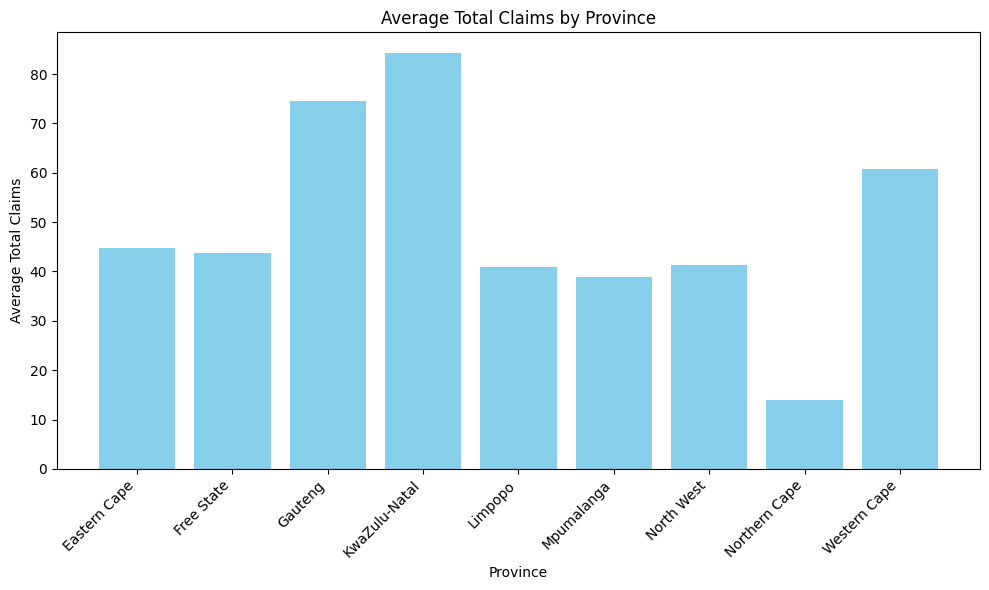

In [7]:
province_avg_claims = data.groupby('Province')['TotalClaims'].mean().reset_index()
create_bar_chart(data=province_avg_claims, x_col='Province', y_col='TotalClaims', title='Average Total Claims by Province', xlabel='Province', ylabel='Average Total Claims')

### Test 2

#### Null Hypothesis: There are no risk differences between zip codes
#### Alternate Hypothesis: There are risk differences between zip codes

#### 1) Check if there are ZIP codes absent


In [8]:
print(f"Missing postal code percentage: {data['PostalCode'].isna().mean()*100}")

Missing postal code percentage: 0.0


#### 2) Run the Annova test instead of A/B test because there are more than 2 zipcodes/postalcodes
#### calculate the p_value using my custom function that uses annova test

In [5]:
# calculate the p_value using my custom function that uses annova test
f_statistics, p_value = perform_anova_test(dependent_col='TotalClaims', independent_col='PostalCode', data=data)

In [6]:
test_hypothesis(null_hypothesis="There are no risk differences between zip codes", p_value=p_value)

Accepted the null hypothesis: There are no risk differences between zip codes
p_value: 0.8906511279164051



##### Visualization

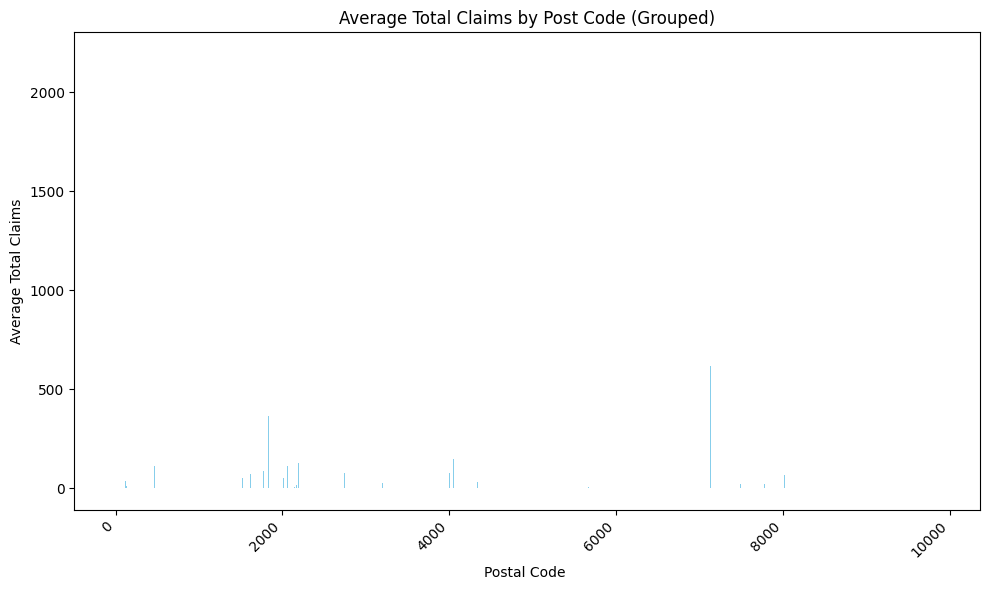

In [8]:
#Visualization
zip_avg_claims = data.groupby('PostalCode')['TotalClaims'].mean().reset_index()
create_bar_chart(data=zip_avg_claims, x_col='PostalCode', y_col='TotalClaims', title='Average Total Claims by Post Code (Grouped)', xlabel='Postal Code ', ylabel='Average Total Claims')

### Test 3
#### Null Hypothesis: There are no significant margin (profit) difference between zip codes
#### Alternate Hypothesis: There are significant margin (profit) difference between zip codes

#### 1) First calculate the margin(profit)

In [9]:
data = calculate_profit(data)

#### 2) Run the Kruskal Wallis test
##### calculate the p_value using my custom function that uses annova test

In [11]:
f_statistics, p_value = perform_anova_test(data=data, dependent_col='Profit', independent_col='PostalCode')

#### 3) Accept or reject the hypothesis based on the p_value result

In [12]:
test_hypothesis(null_hypothesis="There are no significant margin (profit) difference between zip codes", p_value=p_value)

Accepted the null hypothesis: There are no significant margin (profit) difference between zip codes
p_value: 0.9976859758015036



#### Visualization

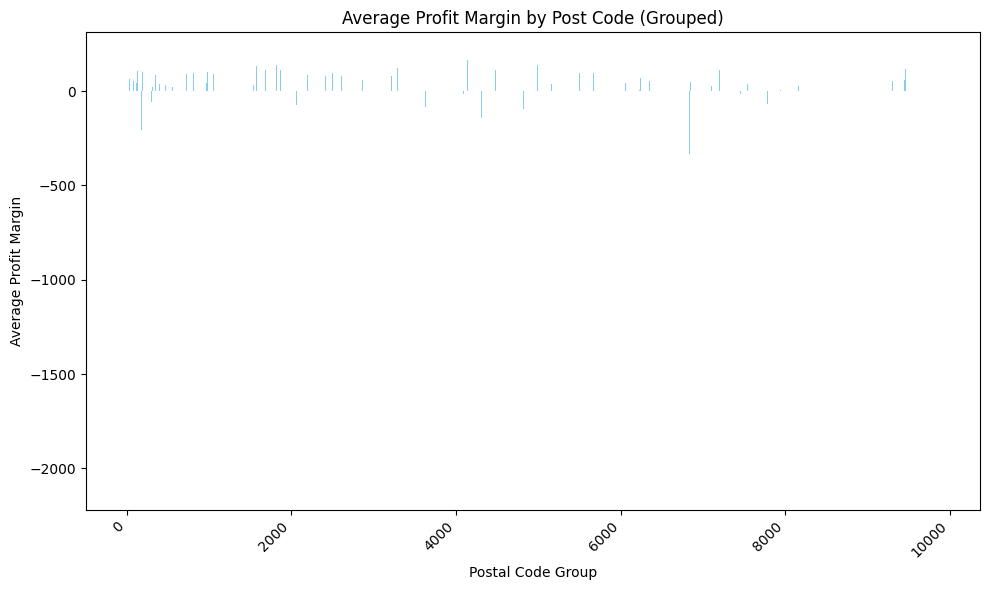

In [13]:
zip_avg_profit = data.groupby('PostalCode')['Profit'].mean().reset_index()
create_bar_chart(data=zip_avg_profit, x_col='PostalCode', y_col='Profit', title='Average Profit Margin by Post Code (Grouped)', xlabel='Postal Code Group', ylabel='Average Profit Margin')


### Test 4
#### Null Hypothesis: There are not significant risk difference between Women and Men
#### Alternate Hypothesis: There are significant risk difference between Women and Men

##### 1) Check for missing gender data values

In [14]:
print(f"Missing gender data percentage: {data['Gender'].isna().mean() * 100}")

Missing gender data percentage: 0.9535065563574769


In [15]:
# Check the available values in the Gender column
print(f"Unique values in the gender column: {data['Gender'].unique()}")

Unique values in the gender column: ['Not specified' 'Male' 'Female' nan]


In [18]:
data['Gender'].isna().mean() * 100

np.float64(0.0)

##### 2) Since there are 3 values for the Gender column, let me check the amount of data for each possible value

In [16]:
count_group_contribution(data=data, grouping_col='Gender')

Not specified: 94.09% of the data
Male: 4.28% of the data
Female: 0.68% of the data


 The data at hand is imbalanced when it comes to gender. I say that because for one the data points that have a value of 'Not specified' account for 95% while female and male combined account for a little over 5%. The other reason is even if I try to check if the data supports or rejects the hypothesis for differences in male and female the amount of data difference between them makes the result ambiguous

#### Filter the data with
#### 3) Run the A/B test
##### just keep the data points that are either male or female

In [20]:
# just keep the datapoints that are either male or female
male_female_df = data[data['Gender'] !=  'Not specified']

# see the new data distribution
count_group_contribution(data=male_female_df, grouping_col='Gender')

Male: 72.44% of the data
Female: 11.43% of the data


In [21]:
# calculate the p_value using my custom function that uses ab test
t_stat, p_value = ab_test(dependent_col='TotalClaims', independent_col='Gender', data=male_female_df)

ValueError: Independent column must have 2 values for A/B test

In [19]:
# calculate the p_value using my custom function that uses ab test
t_stat, p_value = ab_test(dependent_col='TotalClaims', independent_col='Gender', data=male_female_df)

ValueError: Independent column must have 2 values for A/B test

In [22]:

test_hypothesis(null_hypothesis="There are not significant risk difference between Women and Men", p_value=p_value)

Accepted the null hypothesis: There are not significant risk difference between Women and Men
p_value: 0.9976859758015036



Rejected the null hypothesis: There are not significant risk difference between Women and Men
p_value: 0.009847554859932653



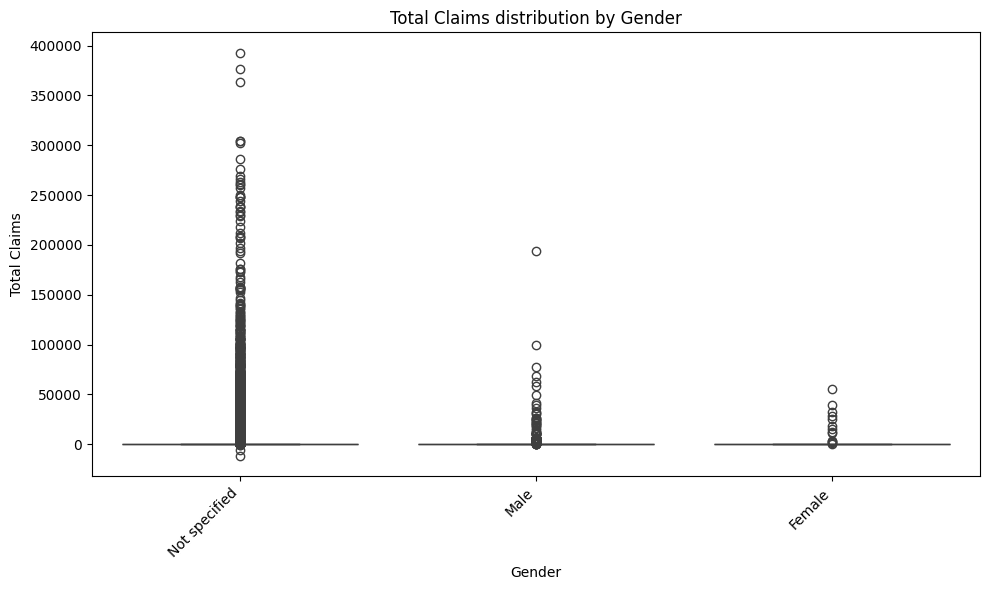

In [23]:
# 5) I decided to run an Anova Test on the entire gender data and see if there is a difference in result
# calculate the p_value using my custom function that uses annova test
f_statistics, p_value = perform_anova_test(data=data, dependent_col='TotalClaims', independent_col='Gender')
test_hypothesis(null_hypothesis="There are not significant risk difference between Women and Men", p_value=p_value)
# Visualization
create_boxplot(data=data, x_col='Gender', y_col='TotalClaims', title='Total Claims distribution by Gender', xlabel='Gender', ylabel='Total Claims')